# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [1]:
import torch.nn
%load_ext autoreload
%autoreload 2

from sys import platform
from utilities import *
from IPython.display import display

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier
from models.bertOne import BertOne

from DrTorch.utilities import DataLoaderFromPipelineStrategy


## Setting the device

In [2]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.0+cu121
Using device: cuda


In [3]:
if device != 'mps':
    !nvidia-smi


Tue Feb 27 18:29:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   57C    P5               9W /  80W |     53MiB /  8188MiB |     12%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining flags and variables

In [4]:
##### PATHS AND DIRECTORY

DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

# Directory paths for model and result storage
BERT_DIRECTORY = "local-bert"
RESULT_DIRECTORY = 'results'  # Directory to store the results
GRID_DIRECTORY = 'grid'  # Directory to store the grid results
WEIGHTS_DIRECTORY = 'weights'  # Directory to store model weights

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 

# File paths for grid search results
FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'freezed_bertone_grid_search_results.pkl')
UNFREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'unfreezed_bertwo_grid_search_results.pkl')

# File paths for model weights
FREEZED_BERTONE_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'freezed_bertone_wights.pth')
UNFREEZED_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'unfreezed_bertone_wights.pth')

# BERT HIDDEN DIMENSION
BERT_HIDDEN_DIM = 768 # bert hidden dimension 
PATIENCE = 3 #Patience of the early stoppers


##### FLAGS FOR MODEL TRAINING AND EVALUATION

# Flags for running additional classifiers
RUN_RANDOM_CLF = True
RUN_MAJORITY_CLF = True


# Flags for fitting different BERT models
FIT_FREEZED_BERTONE = True
FIT_UNFREEZED_BERTONE = True


## Dataset Creation and Exploration

In [5]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True, drop=True)

df


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [6]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


### Plotting Word Cloud 

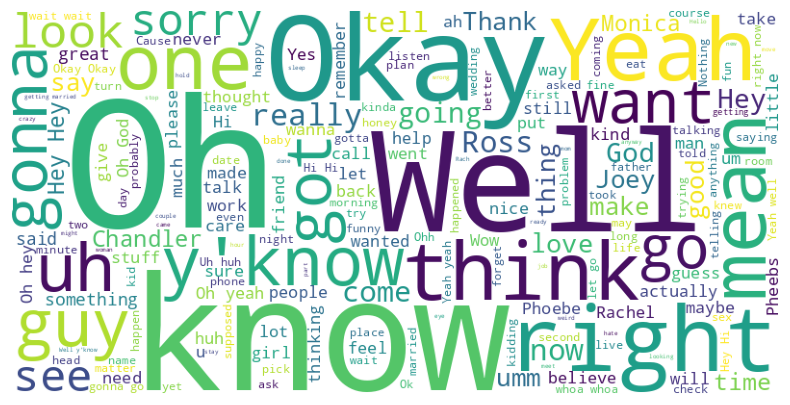

In [7]:
create_wordcloud(df, my_class_index='utterances')


#### Defining same useful variables 

In [8]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
TRIGGERS = np.unique([item for sublist in df["triggers"] for item in sublist])

EMOTIONS_TO_IDX = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
IDX_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}

EMOTIONS_TO_IDX


{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

### Taking a look to same utterance example

In [9]:
display_dialogue(dataframe=df, utterance_id='utterance_6')
display_dialogue(dataframe=df, utterance_id='utterance_456')
display_dialogue(dataframe=df, utterance_id='utterance_2005')

### Removing NaN Values

Utterance 6


,speakers,emotions,utterances,triggers
0,Joey,surprise,But then who? The waitress I went out with las...,0.0
1,Rachel,sadness,You know? Forget it!,0.0
2,Joey,surprise,"No-no-no-no, no! Who, who were you talking about?",0.0
3,Rachel,fear,"No, I-I-I-I don't, I actually don't know",0.0
4,Joey,neutral,Ok!,1.0
5,Joey,neutral,"All right, well...",1.0
6,Rachel,neutral,"Yeah, sure!",0.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


### Analyzing the dataset

In [10]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
    
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in a dialog: {speakers['min_speakers']}")
print(f"Maximum number of speakers in a dialog: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in a dialog: {utterances['length_min']}")
print(f"Maximum number of sentences in a dialog: {utterances['length_max']}")


Number of unique speakers: 231

Minimum number of speakers in a dialog: 1
Maximum number of speakers in a dialog: 8

Minimum number of sentences in a dialog: 2
Maximum number of sentences in a dialog: 24


In [11]:
produce_speaker_emotion_distribution(df)


emotions,anger,disgust,fear,joy,neutral,sadness,surprise
speakers,,,,,,,
Joey,661,149,143,1045,2418,309,841
Ross,541,72,180,967,2280,429,568
Chandler,553,193,203,715,2157,287,560
Rachel,539,146,178,929,1907,566,756
Phoebe,612,117,104,770,1906,409,556
...,...,...,...,...,...,...,...
Another Tour Guide,4,0,0,0,0,0,0
Boy in the Cape,1,0,0,0,0,0,0
Monica and Phoebe,1,0,0,0,0,0,0


### Appling some preprocessing operations 


### Splitting the dataset 

In [12]:
train_df, val_df, test_df = split_dataset(df)

print("Training Set: ")
display(train_df.head())

print("\nValidation Set: ")
display(val_df.head())

print("\nTest Set: ")
display(test_df.head())


Training Set: 


,speakers,emotions,utterances,triggers
index,,,,
utterance_3477,"[Ross, Mona, Ross, Ross, Mona, Ross, Ross, Ros...","[joy, neutral, joy, joy, neutral, neutral, joy...","[Here we go. Mona umm, I think it's time we-we...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_1140,"[Chandler, Issac, Chandler, Joey, Issac, Chand...","[joy, neutral, fear, neutral, neutral, joy]",[Come on Chloe! Finish up with your customer f...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1965,"[Phoebe, Joey, Phoebe, Phoebe, Joey, Phoebe, J...","[neutral, surprise, sadness, neutral, neutral,...","[Hey., Hey. What, what are you doing here?, We...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3382,"[Joey, Chandler, Monica, Joey]","[neutral, disgust, sadness, joy]","[So, did you uh, find anyone to marry you guys...","[0.0, 0.0, 1.0, 1.0]"
utterance_3911,"[Ross, Rachel, Phoebe, Rachel, Ross, Rachel, R...","[joy, fear, neutral, sadness, anger, neutral, ...","[So your dad dropped by. He's a pleasant man!,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"



Validation Set: 


,speakers,emotions,utterances,triggers
index,,,,
utterance_3141,"[Phoebe, Monica, Rachel, Rachel, Monica, Phoebe]","[surprise, neutral, neutral, neutral, neutral,...","[Oh, I want to look too! . Yikes!, So do you t...","[1.0, 0.0, 0.0, 1.0, 1.0, 1.0]"
utterance_3676,"[Phoebe, Phoebe]","[neutral, anger]","[Okay, then what happened?, Ohh. Uh-huh. Uh-hu...","[0.0, 1.0]"
utterance_980,"[Chandler, Ross, Chandler, Ross, Chandler]","[neutral, neutral, surprise, neutral, joy]","[Hey., Chandler. I sensed it was you., What?!,...","[0.0, 0.0, 0.0, 1.0, 1.0]"
utterance_1124,"[Barry, Bernice, Barry, Barry, Barry, Rachel, ...","[fear, fear, fear, neutral, fear, neutral, neu...","[Sweetheart, just gimme- gimme another chance,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_951,"[Rachel, Ross, Rachel, Ross, Ross, Ross, Ross]","[sadness, neutral, anger, neutral, neutral, ne...","[That's right, still no baby! Come on people!...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]"



Test Set: 


,speakers,emotions,utterances,triggers
index,,,,
utterance_522,"[Chandler, Joey, Chandler, Joey, Chandler, Joe...","[anger, neutral, anger, anger, anger, surprise...","[Ok, so it's just because it was my table, I h...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_1627,"[Joey, Ross, Chandler, Ross, Chandler]","[joy, neutral, neutral, neutral, disgust]","[Oh, it's perfect!, How about you?, It's a kit...","[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2205,"[Ross, Monica, Chandler, Monica, Phoebe, Kyle,...","[joy, joy, surprise, surprise, joy, sadness, n...","[I like this one. It seems to say, ""I love yo...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_3774,"[Rachel, Joey, Rachel, Joey, Rachel]","[surprise, neutral, anger, sadness, sadness]","[What? Why? Where are you?, I'm still on the s...","[0.0, 1.0, 0.0, 1.0, 0.0]"
utterance_1716,"[Tag, Rachel, Tag, Rachel, Ross, Rachel, Chand...","[neutral, surprise, neutral, surprise, neutral...","[This one's from me., Ahh!, It wasn't on your ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Visualizing the classes distribution over the datasets

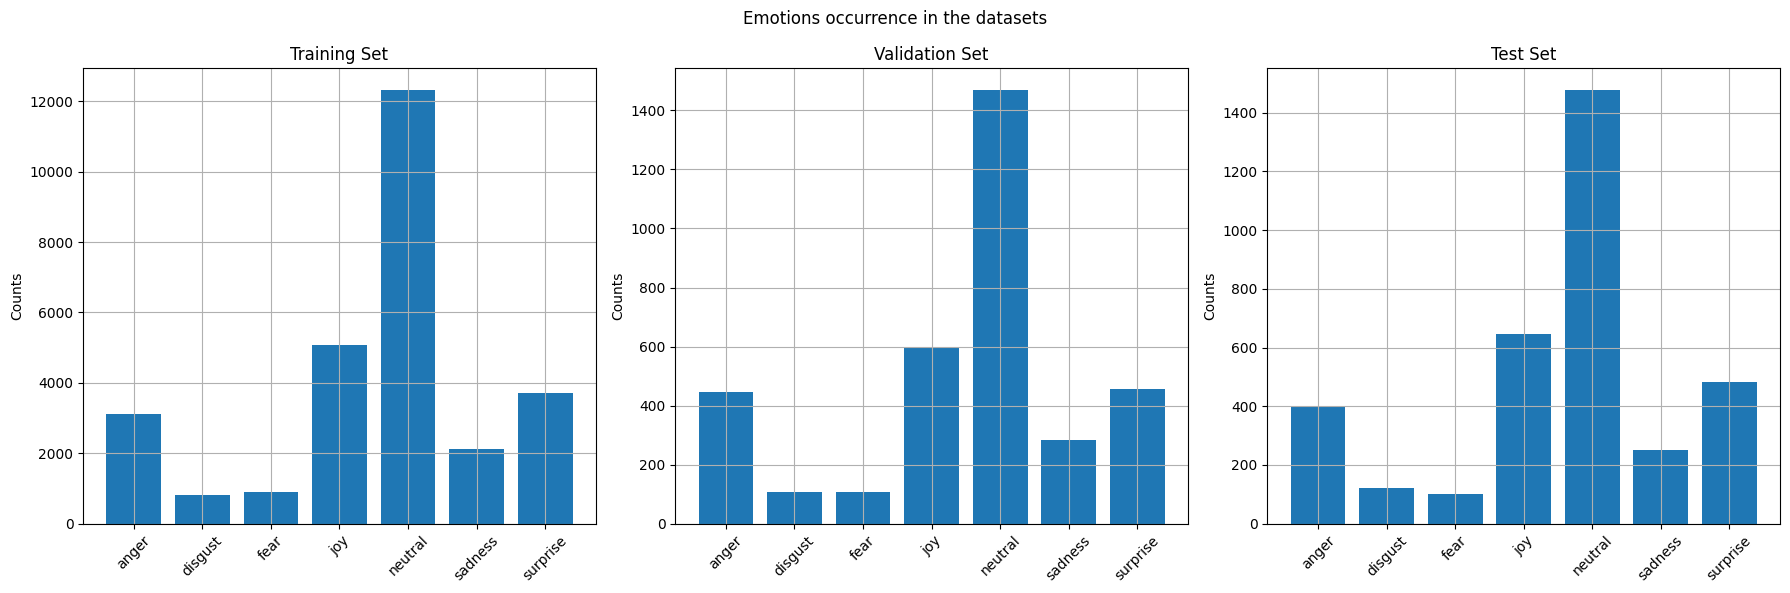

In [13]:
plot_emotion_distribution(train_df, val_df, test_df)


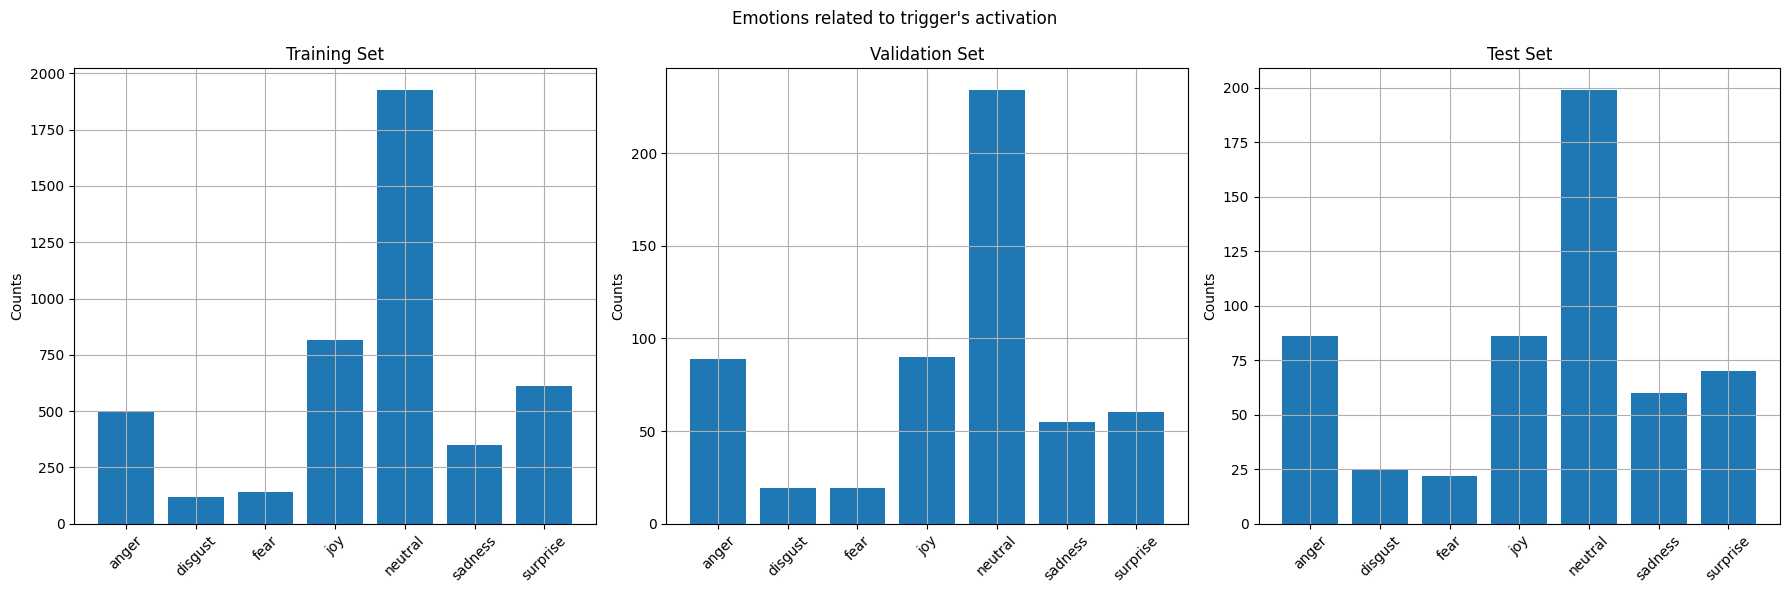

In [14]:
# How many times each emotion activates a trigger
plot_triggers_per_emotion(train_df, val_df, test_df)


### Computing the class weighs 

As we observed, the classes distribution is unbalanced, hence, it may be useful to define a weight policy to determine the importance of each
class in the computation of the loss function. This importance value is a dynamic trainable parameter of the model that changes along the training
process

$$
w_i = \frac{N}{K \cdot N_i}
$$


Here:
- $N$: is the total number of samples;
- $K$: is the number of classes;
- $N_i$: is a sample of class $i$; 


In [15]:
emotion_weights = create_classes_weights([EMOTIONS_TO_IDX[emotion]for emotion in df['emotions'].sum()])
emotion_weights = np.append(emotion_weights, 0)

trigger_weights = create_classes_weights(df['triggers'].sum())
trigger_weights = np.append(trigger_weights, 0)

padded_emotions = list(EMOTIONS) + ['z_emotion']    
padded_triggers = list(TRIGGERS) + [2]

print('Emotion weights')
display(pd.DataFrame({'Emotion': padded_emotions, 'Weight': emotion_weights}))

print('Trigger weights')
display(pd.DataFrame({'Trigger': padded_triggers, 'Weight': trigger_weights}))


Emotion weights


,Emotion,Weight
0,anger,1.261352
1,disgust,4.766444
2,fear,4.488330
3,joy,0.791515
4,neutral,0.327590
5,sadness,1.888218
6,surprise,1.076426
7,z_emotion,0.000000


Trigger weights


,Trigger,Weight
0,0.0,0.594761
1,1.0,3.138206
2,2.0,0.000000


## Random Classifier

In [16]:
# todo metric computation
if RUN_RANDOM_CLF:

    emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
    random_classifier = RandomClassifier(emotions)
    
    pred_emotions, pred_triggers = random_classifier.predict(test_df)
    
    # esempio di print per gli scettici che non crederanno che il classifier funziona
    
    new_test_df = test_df.copy()
    new_test_df['pred_emotions'] = pred_emotions
    new_test_df['pred_triggers'] = pred_triggers
    display_dialogue(dataframe=new_test_df, utterance_id=0)  


Utterance_0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Chandler,anger,"Ok, so it's just because it was my table, I ha...",0.0,neutral,0
1,Joey,neutral,That's the rule.,0.0,fear,1
2,Chandler,anger,"What rule? There's no rule, if anything, you o...",0.0,disgust,0
3,Joey,anger,How'd you get to that?,0.0,surprise,1
4,Chandler,anger,"Well, I believe the piece of furniture was fin...",0.0,surprise,0
5,Joey,surprise,You knew about that?,0.0,fear,0
6,Chandler,disgust,"Well, let's just say the impressions you made ...",0.0,anger,1
7,Joey,neutral,"Ok, ok, How about if we split it?",0.0,anger,1
8,Chandler,neutral,"What do you mean, like, buy it together?",0.0,surprise,1
9,Joey,neutral,Yeah,0.0,anger,0


## Majority Classifier

In [17]:
# todo metrics computation
if RUN_MAJORITY_CLF:
    majority_classifier = MajorityClassifier()
    
    majority_classifier.fit(train_df)
    pred_emotions, pred_triggers = majority_classifier.predict(test_df)
    
    # esempio di print per gli scettici che non crederanno che il classifier funziona
    new_test_df = test_df.copy()
    new_test_df['pred_emotions'] = pred_emotions
    new_test_df['pred_triggers'] = pred_triggers
    display_dialogue(dataframe=new_test_df, utterance_id=0)


Utterance_0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Chandler,anger,"Ok, so it's just because it was my table, I ha...",0.0,neutral,0.0
1,Joey,neutral,That's the rule.,0.0,neutral,0.0
2,Chandler,anger,"What rule? There's no rule, if anything, you o...",0.0,neutral,0.0
3,Joey,anger,How'd you get to that?,0.0,neutral,0.0
4,Chandler,anger,"Well, I believe the piece of furniture was fin...",0.0,neutral,0.0
5,Joey,surprise,You knew about that?,0.0,neutral,0.0
6,Chandler,disgust,"Well, let's just say the impressions you made ...",0.0,neutral,0.0
7,Joey,neutral,"Ok, ok, How about if we split it?",0.0,neutral,0.0
8,Chandler,neutral,"What do you mean, like, buy it together?",0.0,neutral,0.0
9,Joey,neutral,Yeah,0.0,neutral,0.0


## Bert Models

In [18]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(BERT_DIRECTORY)


#### Creating Data Loader

In [21]:
dataLoaderBuilder = DataLoaderFromPipelineStrategy()

train_dataloader = dataLoaderBuilder.create(data=train_df["utterances"].copy(), 
                                            labels=train_df[["emotions", "triggers"]].copy(), 
                                            shuffle=True,
                                            data_preprocess_f=tokenize_data, 
                                            labels_preprocess_f=preprocess_labels,
                                            batch_size=1,
                                            device=device)

val_dataloader = dataLoaderBuilder.create(data=val_df["utterances"].copy(), 
                                          labels=val_df[["emotions", "triggers"]].copy(), 
                                          shuffle=False,
                                          data_preprocess_f=tokenize_data, 
                                          labels_preprocess_f=preprocess_labels,
                                          batch_size=1,
                                          device=device)

test_dataloader = dataLoaderBuilder.create(data=test_df["utterances"].copy(), 
                                           labels=test_df[["emotions", "triggers"]].copy(), 
                                           shuffle=False,
                                           data_preprocess_f=tokenize_data, 
                                           labels_preprocess_f=preprocess_labels,
                                           batch_size=32,
                                           device=device)
    


n_token_per_utterance = next(iter(train_dataloader))[0]['input_ids'].shape[-1] 



### Fitting Freezed BertOne

In [22]:
from DrTorch.metrics import MultyHeadMetric, F1_Score
from DrTorch.callbacks import EarlyStopper
from DrTorch.wrappers import OptimizerWrapper,Criterion, MultyHeadCriterion

torch.manual_seed(42)
np.random.seed(42)

freezed_bert_1 = BertOne(bert_model=bert_model,
                         n_emotions=len(padded_emotions),
                         n_triggers=len(padded_triggers),
                         cls_input_size=n_token_per_utterance*BERT_HIDDEN_DIM,
                         freeze_bert_weights=False).to(device)


if FIT_FREEZED_BERTONE:
        optimizer = OptimizerWrapper(optimizer_constructor=torch.optim.Adam,
                                          identifier=f'lr={1e-5}', 
                                          optimizer_partial_params={'lr': 1e-5})  
        
        emotion_criterion = Criterion(name='emotion_cross_entropy', 
                                      loss_function=torch.nn.CrossEntropyLoss(reduction='none'))  
        
        trigger_criterion = Criterion(name='trigger_cross_entropy', 
                                      loss_function=torch.nn.CrossEntropyLoss(reduction='none'))
        
        multi_head_criterion = MultyHeadCriterion(name='aggregate_cross_entropy',
                                                  loss_functions={'emotions': emotion_criterion, 
                                                                  'triggers': trigger_criterion},
                                                  loss_weights=[1, 1],
                                                  reduction_function=torch.mean)
        
        
        emotion_metric = F1_Score(name='emotion_f1',
                                  mode='macro',
                                  classes_to_exclude=[8],
                                  **{'num_classes': len(padded_emotions)})
        
        trigger_metric = F1_Score(name='triggers_f1',
                                  mode='macro',
                                  classes_to_exclude=[2],
                                  **{'num_classes': len(padded_triggers)})

        
        multi_head_metric = MultyHeadMetric(name='aggregate_avg_f1',
                                            metrics_functions={'emotions': emotion_metric,
                                                               'triggers': trigger_metric},
                                            metric_weights=[1, 1],
                                            aggregate_metrics_function=torch.mean)
        
        
        early_stopper = EarlyStopper(monitor='aggregate_cross_entropy', 
                                     patience=PATIENCE, 
                                     delta=0, 
                                     mode='min',
                                     restore_weights=True)

        freezed_bert_1_history = freezed_bert_1.fit(train_loader=train_dataloader,
                                                    val_loader=val_dataloader,
                                                    criterion=multi_head_criterion,
                                                    metrics=[multi_head_metric],
                                                    optimizer=optimizer,
                                                    early_stopper=early_stopper,
                                                    num_epochs=1)





OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 7.75 GiB of which 13.12 MiB is free. Including non-PyTorch memory, this process has 7.69 GiB memory in use. Of the allocated memory 7.38 GiB is allocated by PyTorch, and 197.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
for data, label in dataloader:
    print("Shape should be: [batch_size, n_frasi,*n_token]")
    print("Shape dei dati: ", data['input_ids'].shape)
    print("Shape delle emotions: ", label["emotions"].shape)
    print("Shape delle triggers: ", label["triggers"].shape)
    break


n_features = n_token_per_utterance * BERT_HIDDEN_DIM


In [ ]:
bertest= BertOne(bert_model=bert_model, cls_input_size=n_features, n_emotions=len(padded_emotions), n_triggers=len(padded_triggers))

for data, label in dataloader:
    pred = bertest(data)
    print(pred)
    break

